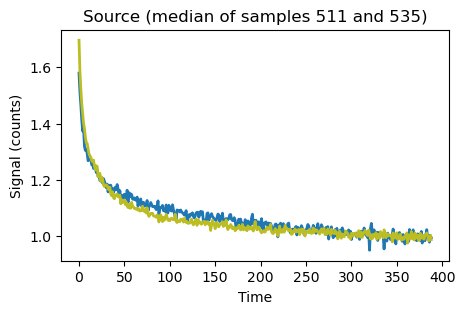

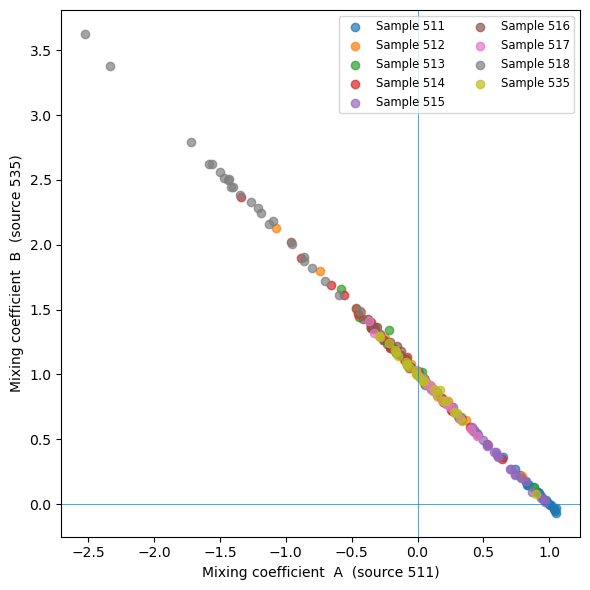

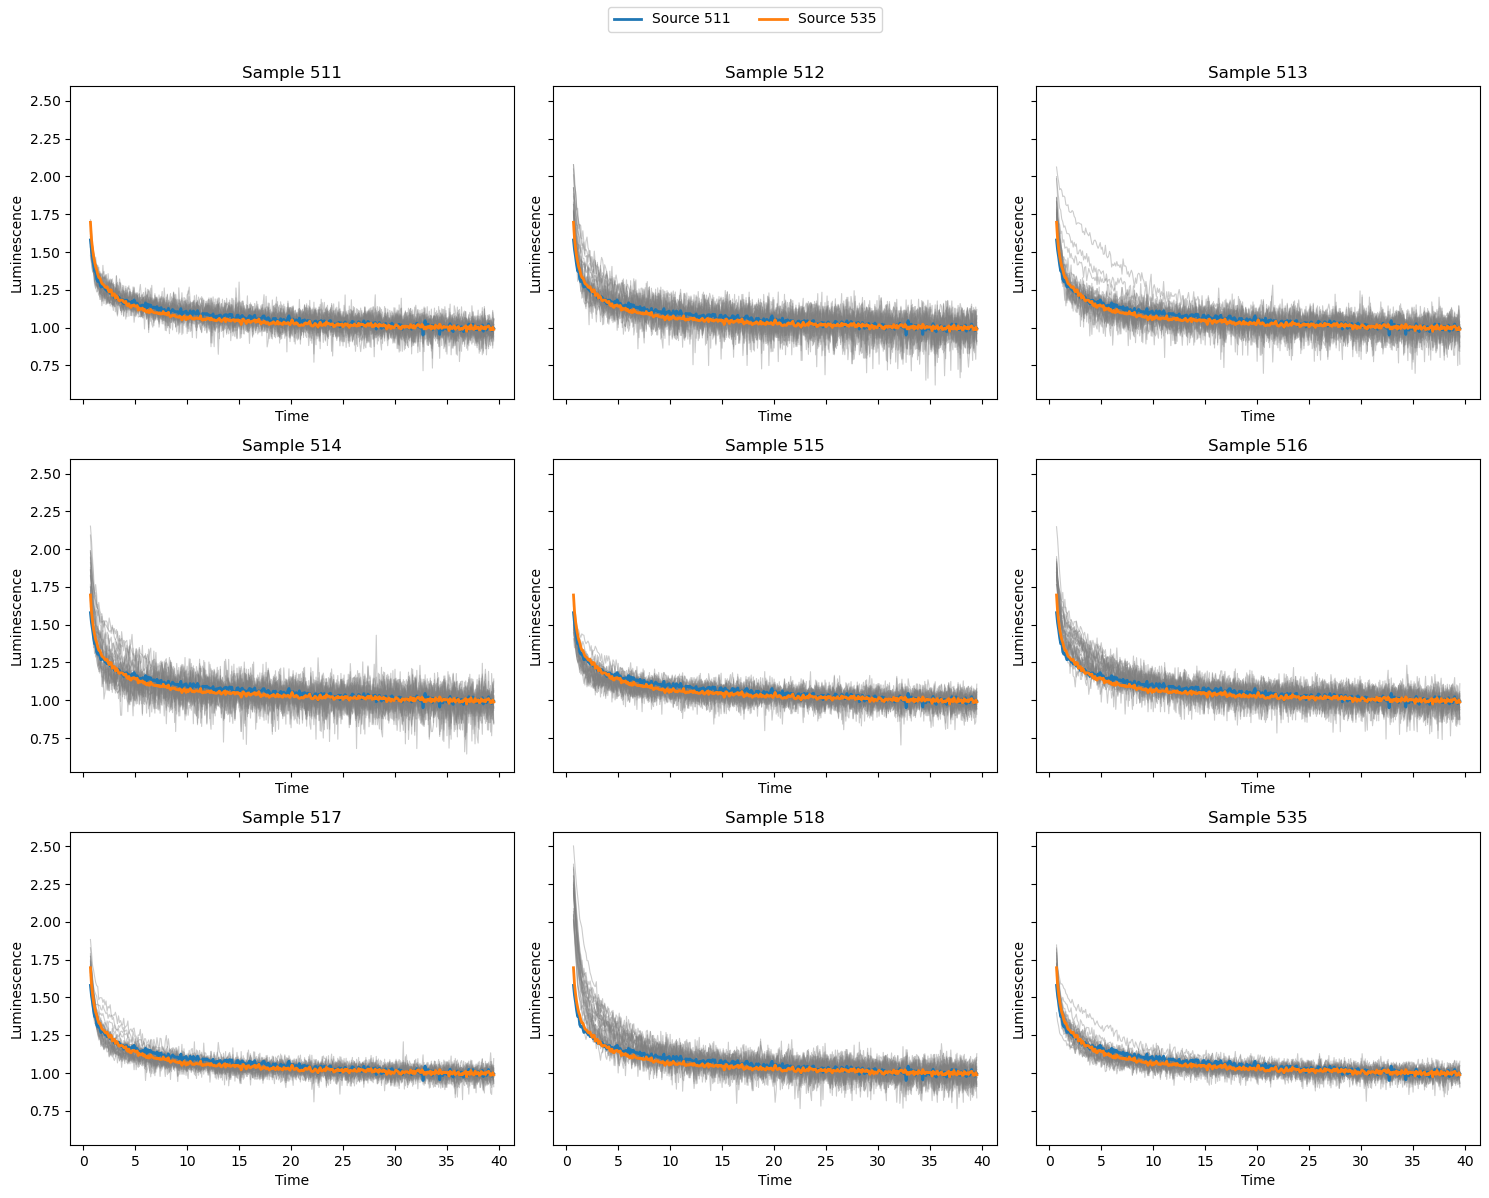

In [40]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# -------------------- Load data --------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found at 'output/processed_data.pkl'.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# -------------------- Helper --------------------
def sample_matrix(sample_key):
    """Return (time, X, slice_names) for a sample.
       X shape: (n_slices, n_time)"""
    df = data_dict[sample_key]
    time = df['Time'].astype(float).values
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    X = df[slice_cols].to_numpy(dtype=float).T
    return time, X, slice_cols



sources = {}

# 直接使用511和535的平均值作为物源
df_temp=data_dict['511']
slice_cols = df_temp.columns.difference(['Time_index', 'Time'])
# calculate the mean of all columns
# mean_values = df_temp[slice_cols].mean(axis=1)
# use median
mean_values = df_temp[slice_cols].median(axis=1)
source1 = mean_values


df_temp=data_dict['535']
slice_cols = df_temp.columns.difference(['Time_index', 'Time'])
# calculate the mean of all columns
# mean_values = df_temp[slice_cols].mean(axis=1)

# use median
mean_values = df_temp[slice_cols].median(axis=1)
source2 = mean_values



cmap            = plt.colormaps['tab10']   

# plot the two sources
fig=plt.figure(figsize=(5, 3))
# # show all slices in of sample 511 in grey
# for sample_key, df in data_dict.items():
#     if sample_key == '511':
#         time = df['Time_index'].astype(float).values
#         slice_cols = df.columns.difference(['Time_index', 'Time'])
#         X = df[slice_cols].to_numpy(dtype=float).T
#         plt.plot(time, X.T, color=cmap(0 % 10), alpha=0.1, lw=0.8)

# # show all slices in of sample 535 in grey
# for sample_key, df in data_dict.items():
#     if sample_key == '535':
#         time = df['Time_index'].astype(float).values
#         slice_cols = df.columns.difference(['Time_index', 'Time'])
#         X = df[slice_cols].to_numpy(dtype=float).T
#         plt.plot(time, X.T, color=cmap(8 % 10), alpha=0.1, lw=0.8)


plt.plot(source1, lw=2, color=cmap(0 % 10), alpha=1, label='Source 511')
plt.plot(source2, lw=2, color=cmap(8 % 10), alpha=1, label='Source 535')
plt.xlabel('Time')
plt.ylabel('Signal (counts)')

fig.savefig('Figures/source_curves.png', dpi=600, bbox_inches='tight')
fig.savefig('Figures/source_curves.pdf', dpi=600, bbox_inches='tight')


plt.title('Source (median of samples 511 and 535)')

# Stack sources into design matrix S of shape (n_time, 2)
S = np.vstack([source1, source2]).T

# Pre-compute pseudo-inverse once for speed
pinv = np.linalg.pinv(S)

# -------------------- Solve A, B for every slice --------------------
results = []   # list of dicts: sample, slice_name, A, B
for sample_key in sorted(data_dict.keys()):
    time, Xs, slice_cols = sample_matrix(sample_key)
    for idx, slice_name in enumerate(slice_cols):
        y = Xs[idx]            # (n_time,)
        A, B = pinv @ y
        results.append({'sample': sample_key, 'slice': slice_name, 'A': A, 'B': B})

results_df = pd.DataFrame(results)

# -------------------- Scatter plot of A vs B --------------------
plt.figure(figsize=(6, 6))
for sample_key, grp in results_df.groupby('sample'):
    plt.scatter(grp['A'], grp['B'], label=f'Sample {sample_key}', alpha=0.7)
plt.axhline(0, lw=0.5); plt.axvline(0, lw=0.5)
plt.xlabel('Mixing coefficient  A  (source 511)')
plt.ylabel('Mixing coefficient  B  (source 535)')
# plt.title('Mixing coefficients for every slice')
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

samples = sorted(data_dict.keys())          # 9 keys → row-major order
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12), sharex=True, sharey=True)

for ax, sample_key in zip(axes.ravel(), samples):
    time, Xs, _ = sample_matrix(sample_key)

    # plot every slice for this sample in grey
    ax.plot(time, Xs.T, color='grey', alpha=0.4, lw=0.8)

    # overlay the two sources
    ax.plot(time, source1, lw=2, label='Source 511')
    ax.plot(time, source2, lw=2, label='Source 535')

    # cosmetics
    ax.set_title(f'Sample {sample_key}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Luminescence')

# One shared legend (outside the grid)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

fig.tight_layout(rect=[0, 0, 1, 0.96])     # leave room for the legend
plt.show()

# See how data fit

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Pre-compute pseudo-inverse once (sources stacked column-wise)
# ------------------------------------------------------------------
S      = np.vstack([source1, source2]).T        # shape (n_time, 2)
S_pinv = np.linalg.pinv(S)                      # shape (2, n_time)

def plot_sample_fits(sample_key, n_cols=4):
    """
    Visual-diagnostic plot of every slice in a sample vs its two-source fit.

    Parameters
    ----------
    sample_key : str
        The key in `data_dict` (e.g. '511').
    n_cols : int, optional
        Number of subplot columns (rows are computed automatically).
    """
    # ---------- pull data ----------
    time, Xs, slice_names = sample_matrix(sample_key)   # Xs: (n_slices, n_time)
    n_slices  = Xs.shape[0]
    n_rows    = int(np.ceil(n_slices / n_cols))

    # ---------- set up figure ----------
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 3*n_rows),
                             sharex=True, sharey=True)
    axes = axes.ravel()       # flatten for easy indexing

    # ---------- iterate over slices ----------
    for i in range(n_slices):
        ax   = axes[i]
        y    = Xs[i]

        # optimal (A, B) by least squares
        A, B = S_pinv @ y
        yhat = A*source1 + B*source2
        rmse = np.sqrt(np.mean((y - yhat)**2))
        # normalize the rmse to the mean of the slice
        rmse /= np.mean(y) if np.mean(y) != 0 else 1e-10

        # plot
        ax.plot(time, y,           lw=1,  color='grey', label='slice')
        ax.plot(time, yhat,        lw=1.6, linestyle='-', color='r', label='fit')
        ax.set_title(f'{slice_names[i]}\nA={A:.2f}, B={B:.2f}, RMSE={rmse:.3g}',
                     fontsize=9)

    # remove empty axes (if slice count isn’t a multiple of n_cols)
    for j in range(n_slices, n_rows*n_cols):
        fig.delaxes(axes[j])

    # one common legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    # fig.suptitle(f'Sample {sample_key}: slice vs. two-source fit', y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


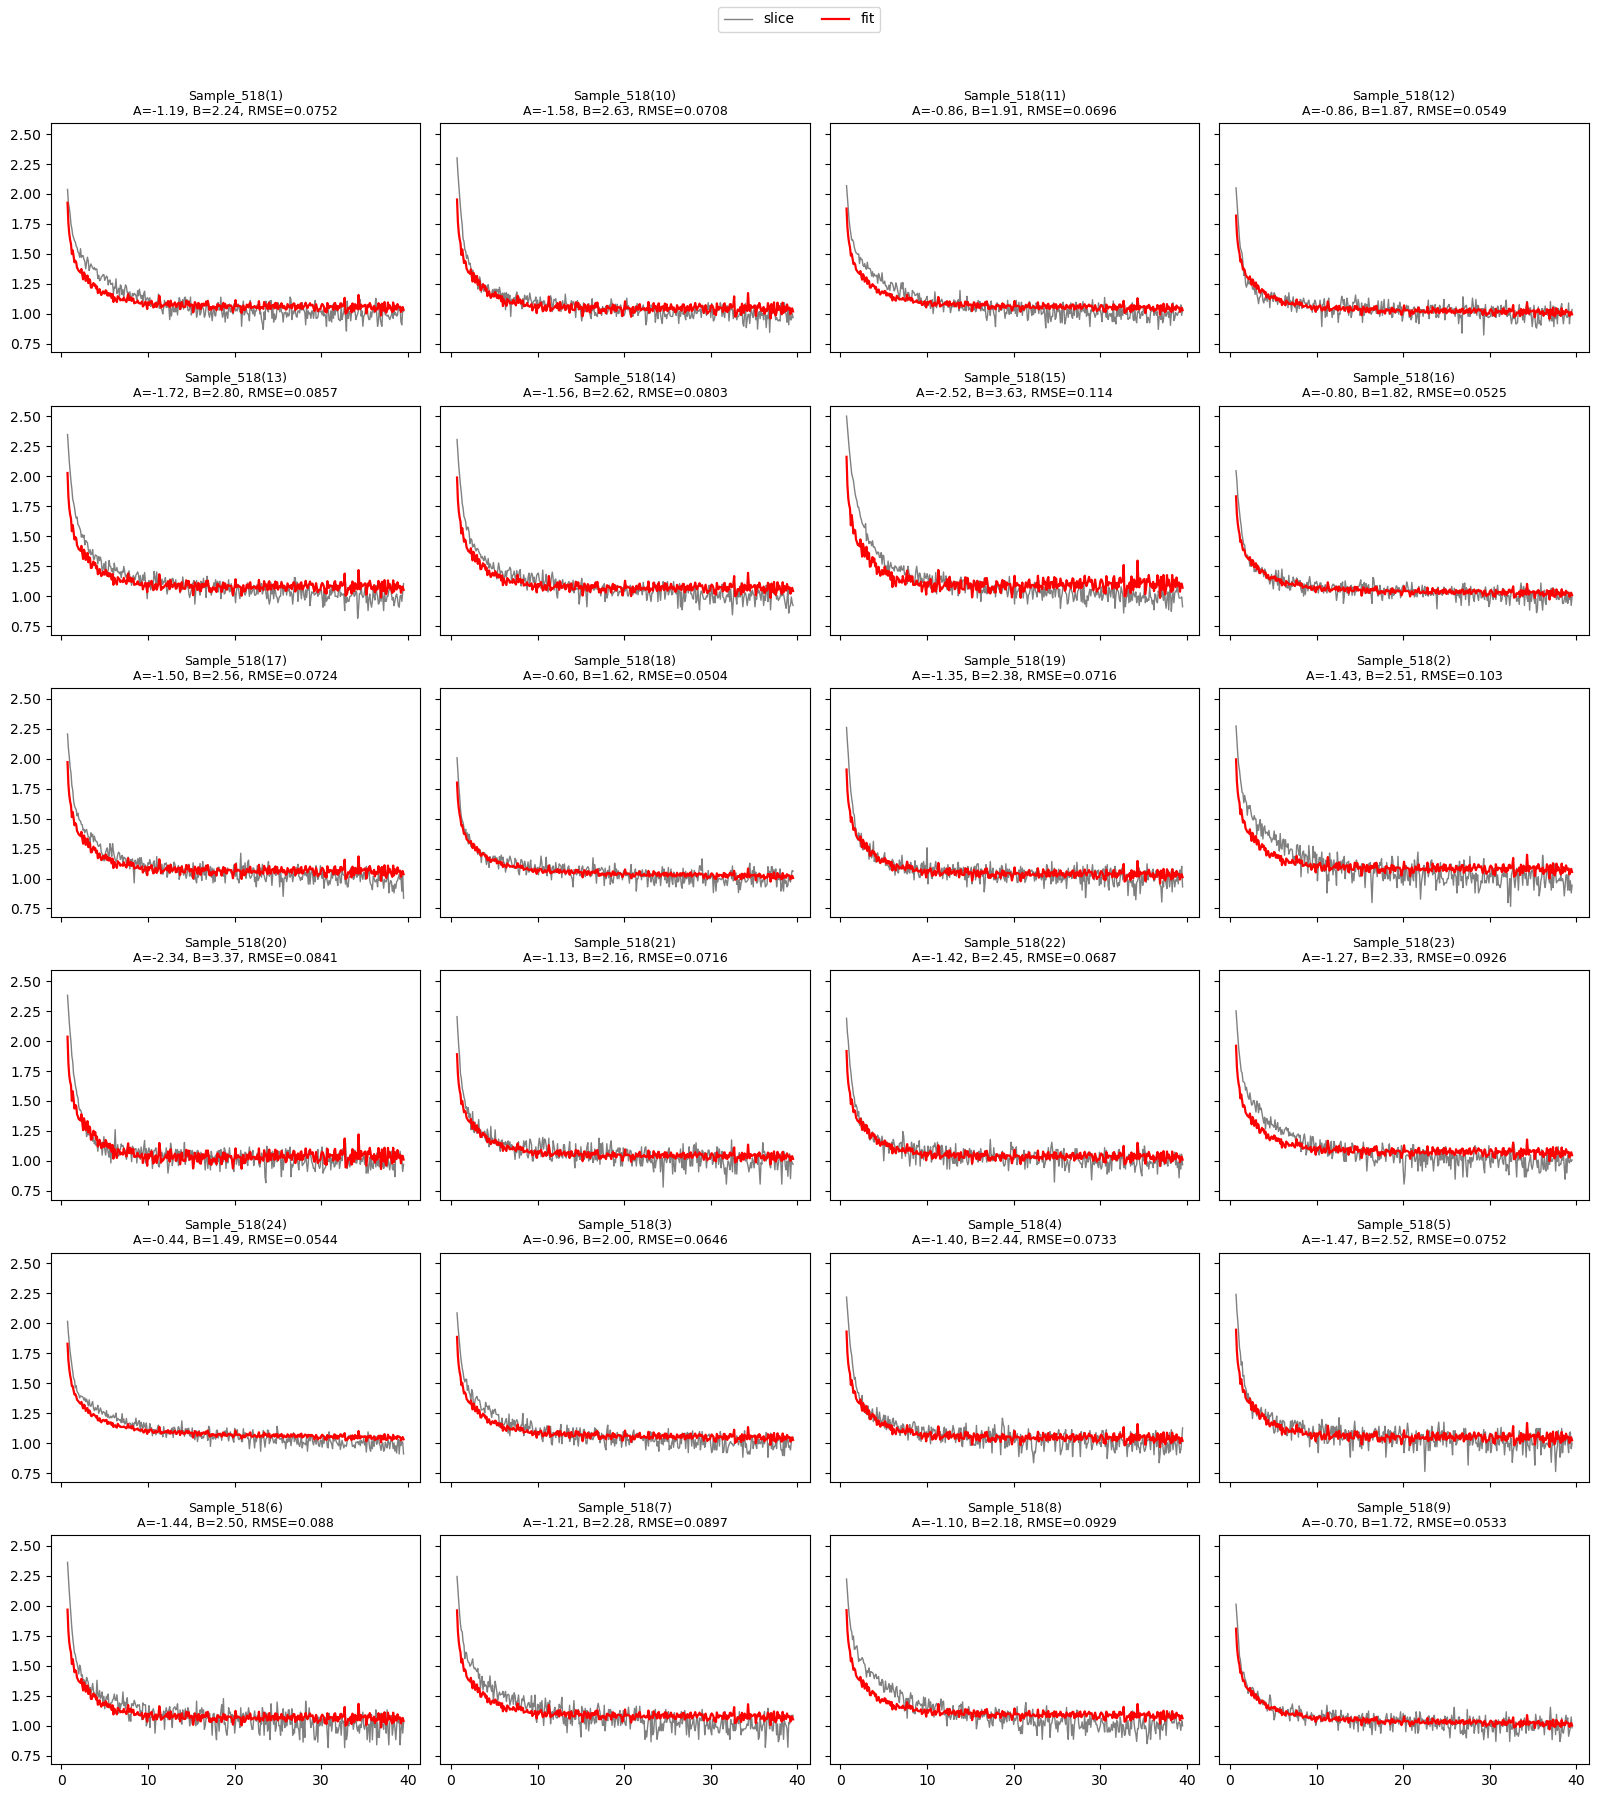

In [133]:
plot_sample_fits('518')    # or any of the 9 sample keys


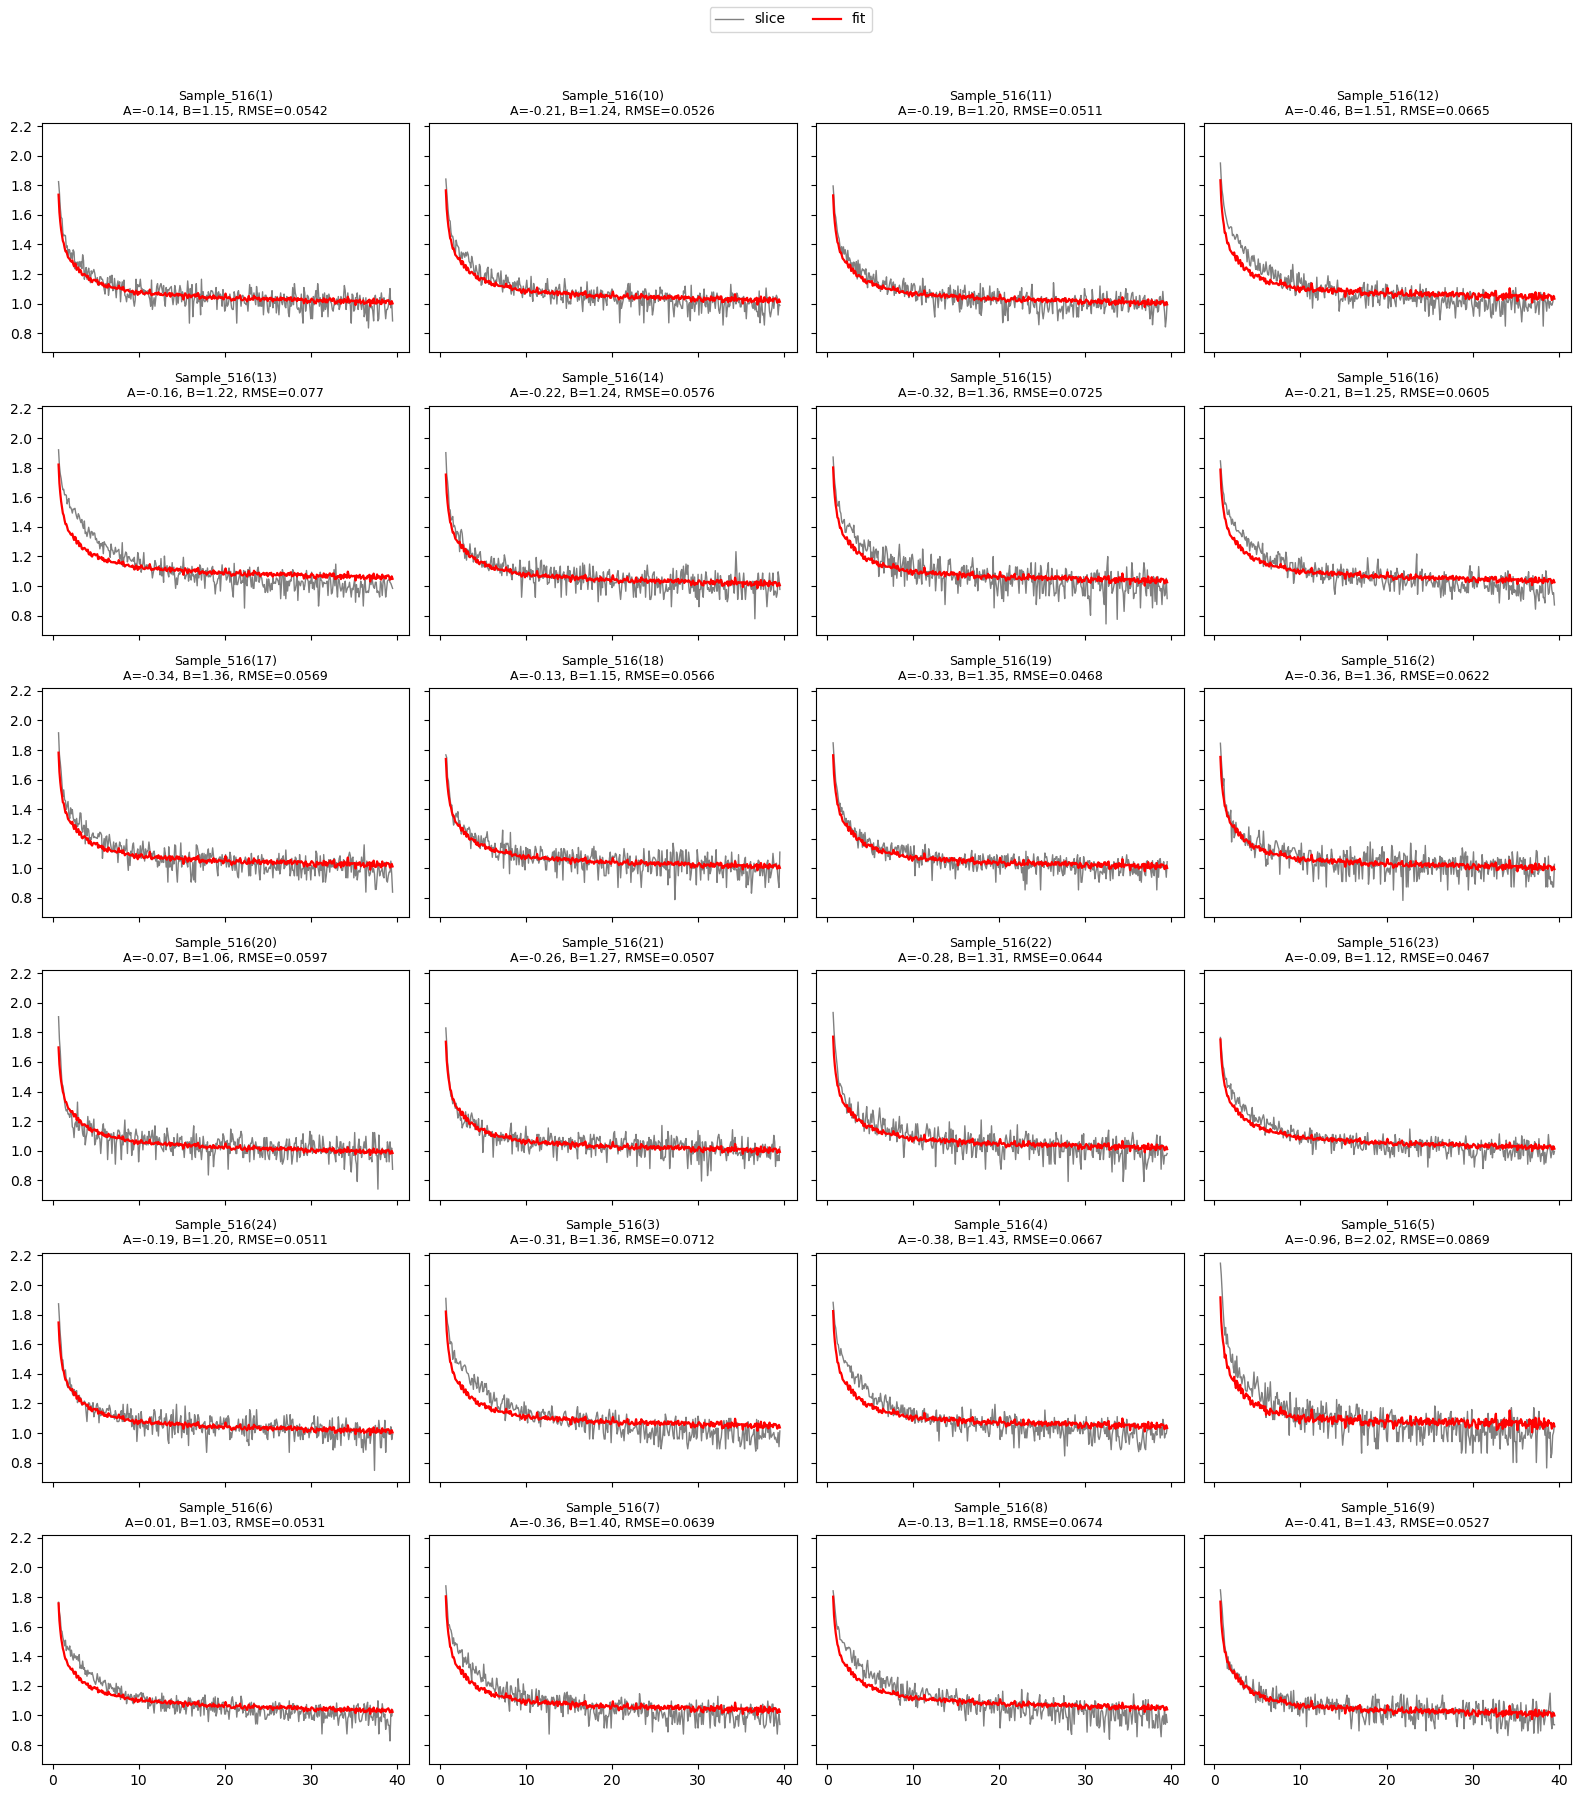

In [82]:
plot_sample_fits('516')    # or any of the 9 sample keys

# See how the RMSE distribute

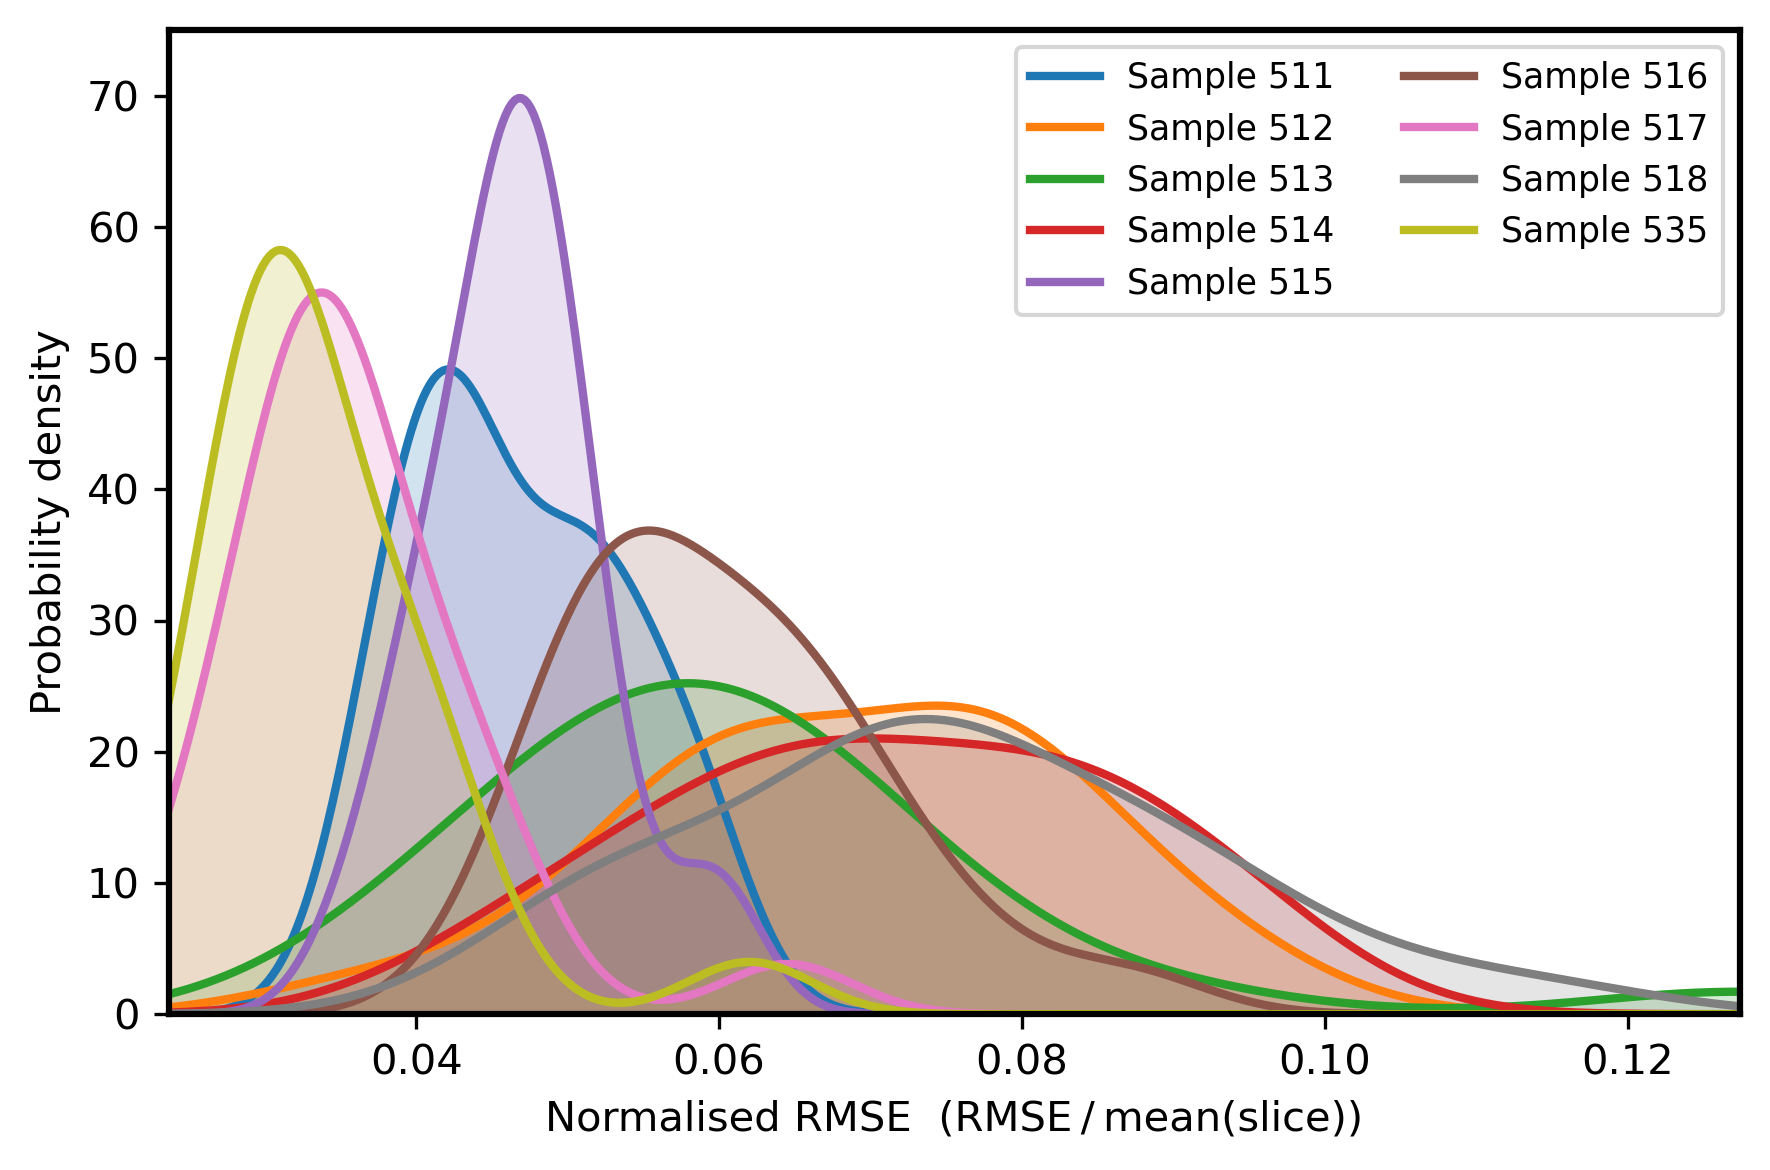

In [30]:
# --------------------------------------------------------------
# Plot KDE “fits” to the per‑sample RMSE distributions
# --------------------------------------------------------------
from scipy.stats import gaussian_kde        # <-- new import

S      = np.vstack([source1, source2]).T        # shape (n_time, 2)
S_pinv = np.linalg.pinv(S)                      # shape (2, n_time)

cmap            = plt.colormaps['tab10']           # 10 qualitative colours
norm_rmse_dict  = {}                               # {sample: 1‑D array}

for i, sample_key in enumerate(sorted(data_dict.keys())):
    time, Xs, _ = sample_matrix(sample_key)        # (n_slices, n_time)
    rmse_list   = []

    for y in Xs:
        A, B  = S_pinv @ y
        yhat  = A*source1 + B*source2
        rmse  = np.sqrt(np.mean((y - yhat)**2))
        rmse /= np.mean(y) if np.mean(y) != 0 else 1e-10   # normalise
        rmse_list.append(rmse)

    norm_rmse_dict[sample_key] = np.asarray(rmse_list)

# ------- common binning so the histograms align -------------------
all_vals = np.concatenate(list(norm_rmse_dict.values()))
bins     = np.linspace(all_vals.min(), all_vals.max(), 30)

fig=plt.figure(figsize=(6, 4),dpi=300)

# x‑grid common to all curves
x_grid = np.linspace(all_vals.min(), all_vals.max(), 500)

for i, (sample_key, vals) in enumerate(norm_rmse_dict.items()):
    kde  = gaussian_kde(vals, bw_method='scott')   # Scott’s rule bandwidth
    pdf  = kde(x_grid)                             # evaluate on grid
    

    plt.plot(x_grid, pdf,
             lw=2, color=cmap(i % 10),
             label=f'Sample {sample_key}')
    plt.fill_between(x_grid, 0, pdf,
                     color=cmap(i % 10), alpha=0.20)   # optional shading
    
# set x lim to the min/max of all samples
plt.xlim(all_vals.min(), all_vals.max())
plt.ylim(0, 75)         # y lim to the max of all samples

# set the linewidth of spines to 1.5
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)

plt.xlabel('Normalised RMSE  (RMSE / mean(slice))')
plt.ylabel('Probability density')
# plt.title('Kernel‑density fit of normalised RMSE for every sample')
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

fig.savefig('Figures/nRMSE_hist.png', dpi=600, bbox_inches='tight')
fig.savefig('Figures/nRMSE_hist.pdf', dpi=600, bbox_inches='tight')

In [15]:
# ------------------------------------------------------------------
# Analysis: median RMSE per sample  →  t‑test between two groups
# ------------------------------------------------------------------
from scipy.stats import ttest_ind

# ❶  median of the per‑slice normalised‐RMSE for every sample
sample_median = {k: np.median(v) for k, v in norm_rmse_dict.items()}

# ❷  define the two groups
group_hi_keys = ['512', '514', '518']                    # “high‑RMSE” group
group_lo_keys = [k for k in sample_median if k not in group_hi_keys]

group_hi_vals = [sample_median[k] for k in group_hi_keys]
group_lo_vals = [sample_median[k] for k in group_lo_keys]

print("Median normalised‑RMSE by sample:")
for k, m in sample_median.items():
    print(f"  {k}: {m:.4f}")

# ❸  Welch’s two‑sample t‑test (unequal variance)
t_stat, p_val = ttest_ind(group_hi_vals, group_lo_vals,
                          equal_var=False)

print("\nWelch t‑test comparing medians")
print("--------------------------------")
print(f"Group‑HI samples: {group_hi_keys}")
print(f"Group‑LO samples: {group_lo_keys}")
print(f"t‑statistic = {t_stat:.3f}")
print(f"p‑value     = {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print(f"Result: p < {alpha} → the high‑RMSE group has a significantly "
          "higher median normalised‑RMSE.")
else:
    print(f"Result: p ≥ {alpha} → no significant difference in medians.")


Median normalised‑RMSE by sample:
  511: 0.0451
  512: 0.0695
  513: 0.0585
  514: 0.0698
  515: 0.0466
  516: 0.0587
  517: 0.0340
  518: 0.0729
  535: 0.0316

Welch t‑test comparing medians
--------------------------------
Group‑HI samples: ['512', '514', '518']
Group‑LO samples: ['511', '513', '515', '516', '517', '535']
t‑statistic = 5.143
p‑value     = 0.0028
Result: p < 0.05 → the high‑RMSE group has a significantly higher median normalised‑RMSE.


In [ ]:
# ------------------------------------------------------------------
# Analysis: slice‑level t‑test between two groups of samples
# ------------------------------------------------------------------
from scipy.stats import ttest_ind

# ❶  build the two groups of *slice* values
group_hi_keys = {'512', '514', '518'}                # set for fast lookup
group_hi_vals = []
group_lo_vals = []

for k, arr in norm_rmse_dict.items():
    if k in group_hi_keys:
        group_hi_vals.extend(arr)                    # add all slice RMSEs
    else:
        group_lo_vals.extend(arr)

group_hi_vals = np.asarray(group_hi_vals)
group_lo_vals = np.asarray(group_lo_vals)

print(f"Group HI  (samples 512, 514, 518): {group_hi_vals.size} slices")
print(f"Group LO  (other samples)        : {group_lo_vals.size} slices")

# ❷  Welch’s t‑test (unequal variances, unequal Ns)
t_stat, p_val = ttest_ind(group_hi_vals, group_lo_vals, equal_var=False)

print("\nWelch t‑test on slice‑level normalised‑RMSE")
print("--------------------------------------------")
print(f"t‑statistic = {t_stat:.3f}")
print(f"p‑value     = {p_val:.4g}")

alpha = 0.05
if p_val < alpha:
    print(f"Conclusion: p < {alpha} — the HI group has a significantly "
          "different mean normalised‑RMSE.")
else:
    print(f"Conclusion: p ≥ {alpha} — no significant difference detected.")


Group HI  (samples 512, 514, 518): 71 slices
Group LO  (other samples)        : 144 slices

Welch t‑test on slice‑level normalised‑RMSE
--------------------------------------------
t‑statistic = 11.196
p‑value     = 5.218e-21
Conclusion: p < 0.05 — the HI group has a significantly different mean normalised‑RMSE.


# Mixing ratio in each slice

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_AB_across_slices(results_df, n_cols=3):
    """
    3×3 (or smaller) grid: A and B vs. slice index for every sample,
    with horizontal lines showing per-sample means.
    """
    samples   = sorted(results_df['sample'].unique())
    n_samples = len(samples)
    n_rows    = int(np.ceil(n_samples / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 3*n_rows),
                             sharey=True, dpi=300)

    axes_flat = np.ravel(axes)

    for idx, (ax, sample_key) in enumerate(zip(axes_flat, samples)):
        grp = results_df.loc[results_df['sample'] == sample_key].reset_index(drop=True)
        x   = np.arange(len(grp))

        # scatter/line for individual slices
        ax.plot(x, grp['A'], marker='o', lw=1.5, label='A (source 511)')
        ax.plot(x, grp['B'], marker='o', lw=1.5, label='B (source 535)')

        # per-sample means
        mean_A = grp['A'].mean()
        mean_B = grp['B'].mean()
        ax.axhline(mean_A, ls='--', lw=1, color='tab:blue')
        ax.axhline(mean_B, ls='--', lw=1, color='tab:red')

        ax.axhline(0, color='k', lw=0.5)
        # ax.set_xlabel('Slice index')
        # only show x labels on the bottom row
        if idx >= (n_rows-1) * n_cols:
            ax.set_xlabel('Slice index')
        else:
            ax.set_xticklabels([])
        if idx % n_cols == 0:
            ax.set_ylabel('Mixing coefficient')

        ax.set_title(f'Sample {sample_key}\n⟨A⟩={mean_A:.2f}, ⟨B⟩={mean_B:.2f}',
                     fontsize=10)
        
        # set the linewidth of spines to 1.5
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)

    # hide unused panels
    for extra_ax in axes_flat[n_samples:]:
        extra_ax.set_visible(False)

    # single legend (first axis has the handles)
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    fig.savefig('Figures/AandB.png', dpi=600, bbox_inches='tight')
    fig.savefig('Figures/AandB.pdf', dpi=600, bbox_inches='tight')


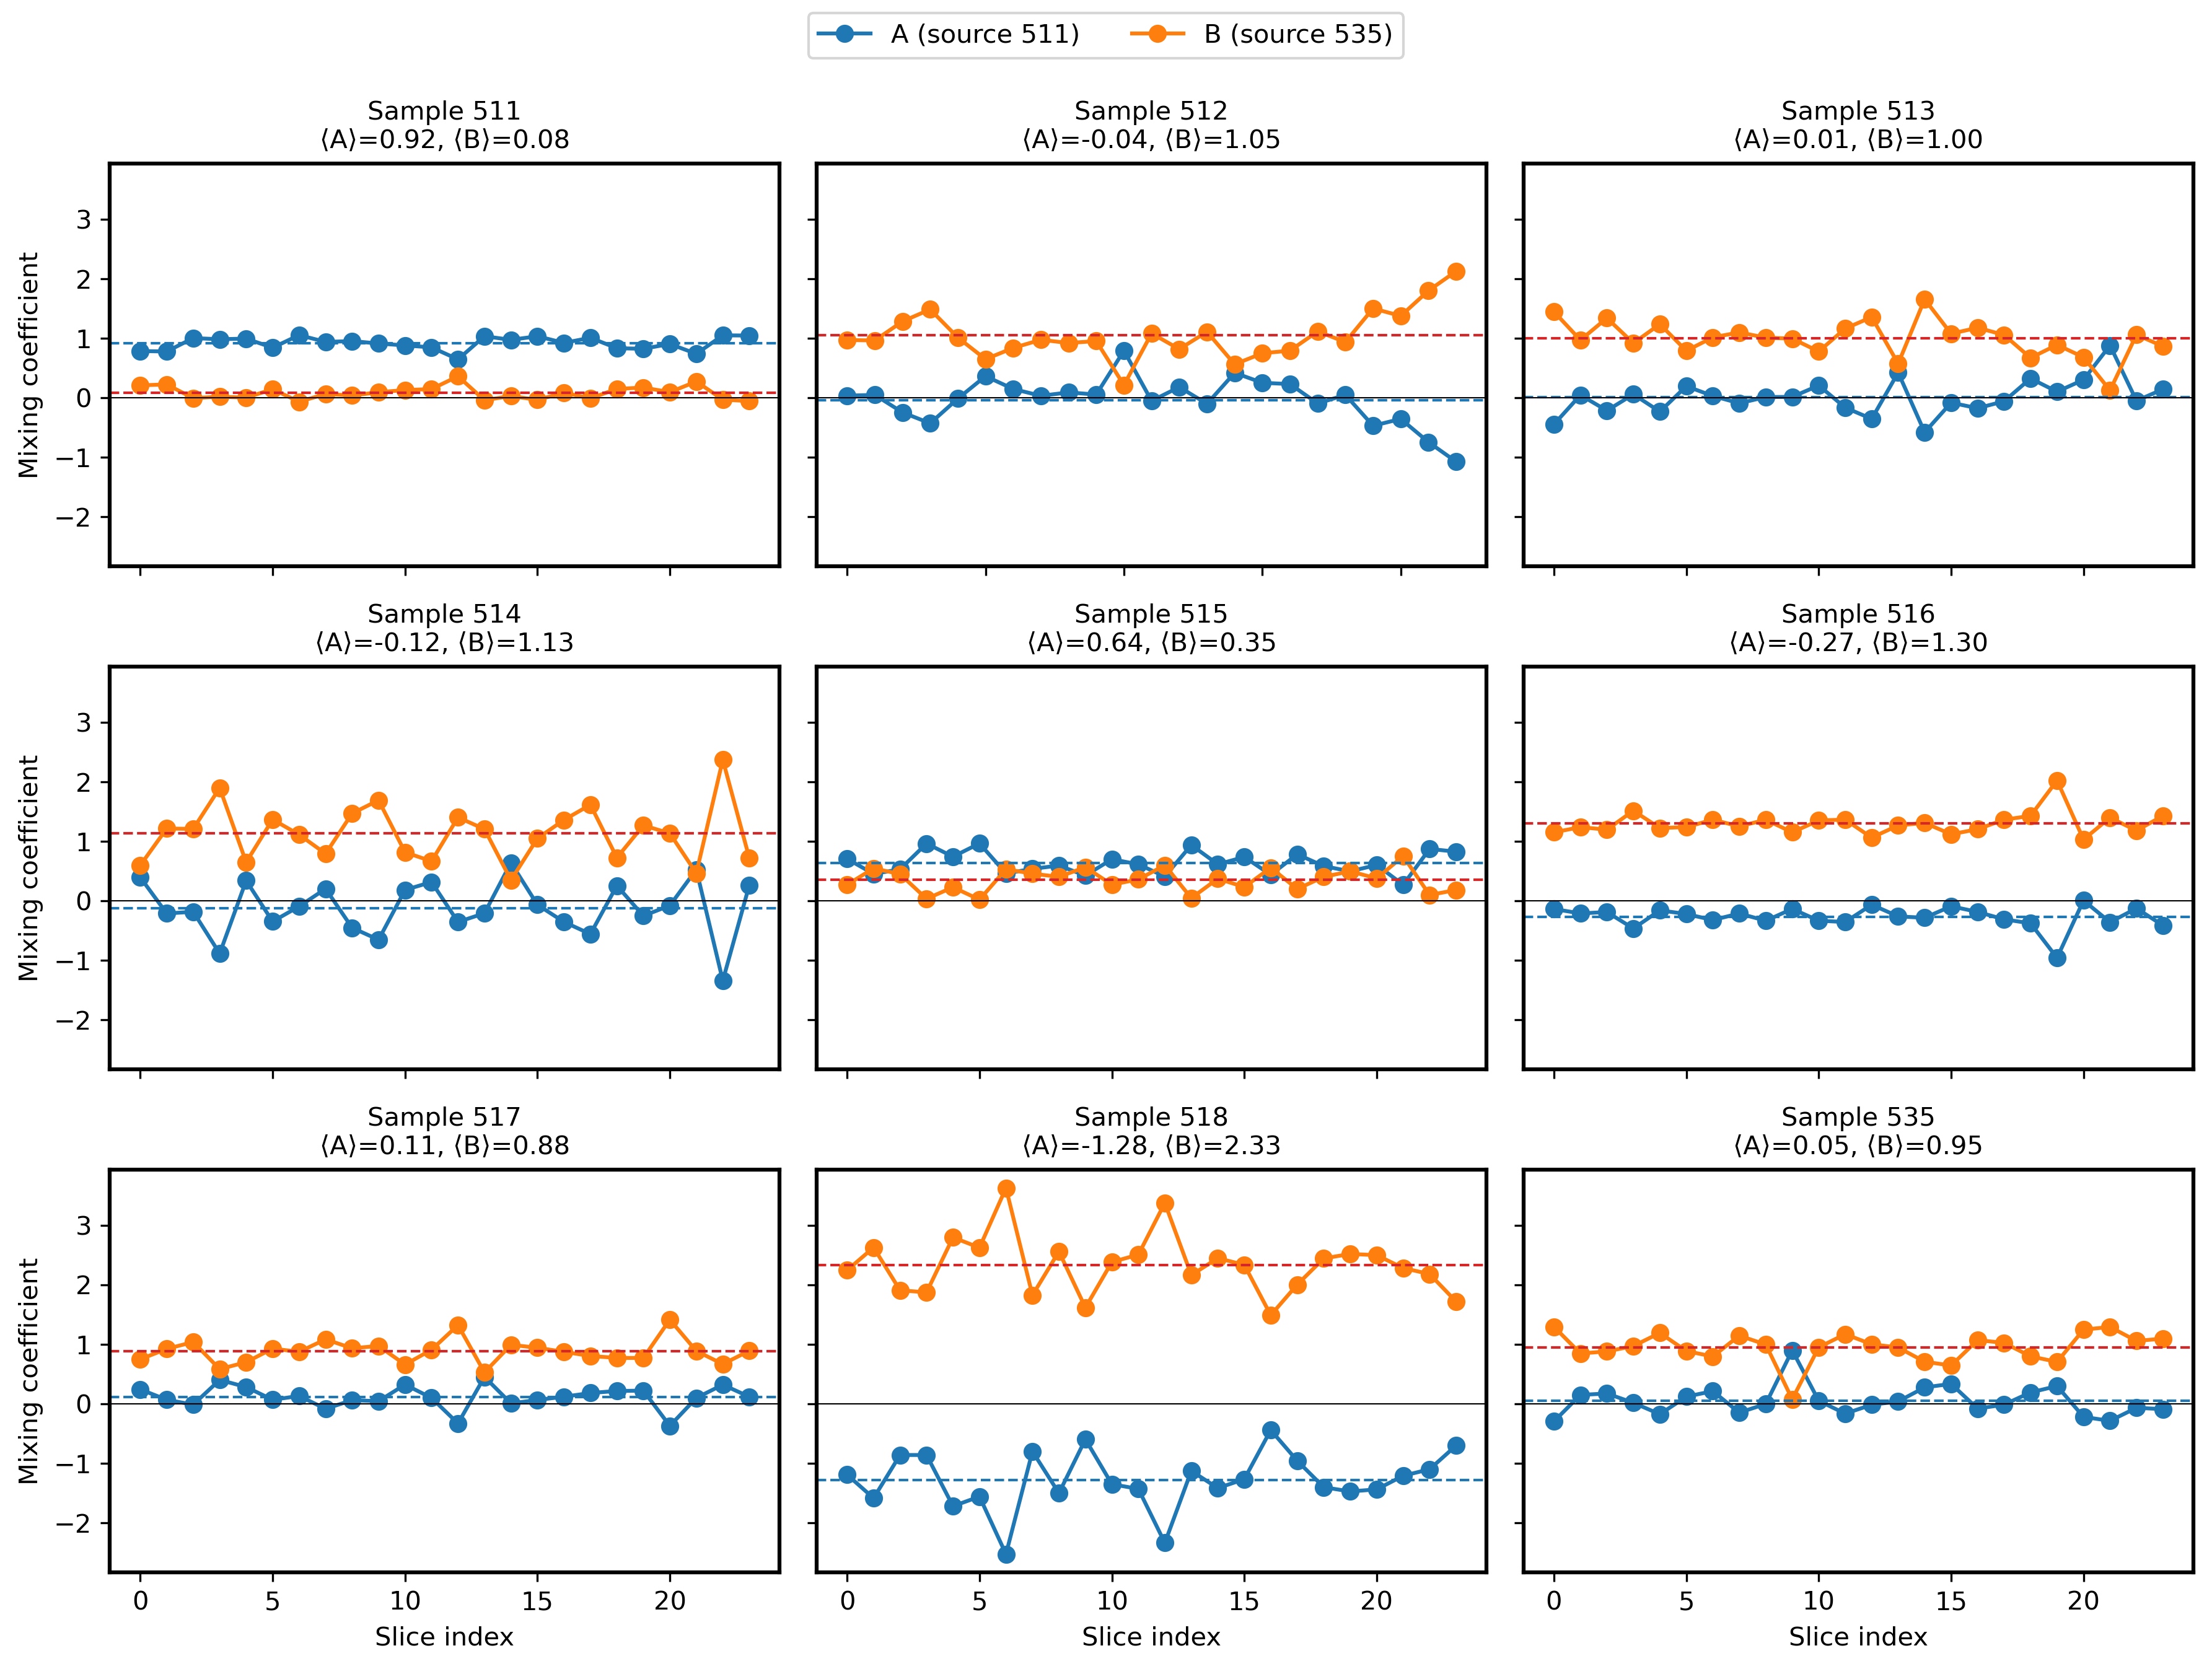

In [28]:
plot_AB_across_slices(results_df)


# 使用511和535的mean作为两个物源：
## 518 516 514 不属于 由 511和535组成的物源体系
## 512， 513， 517 物源主要受535控制
## 515 物源主要受 511控制


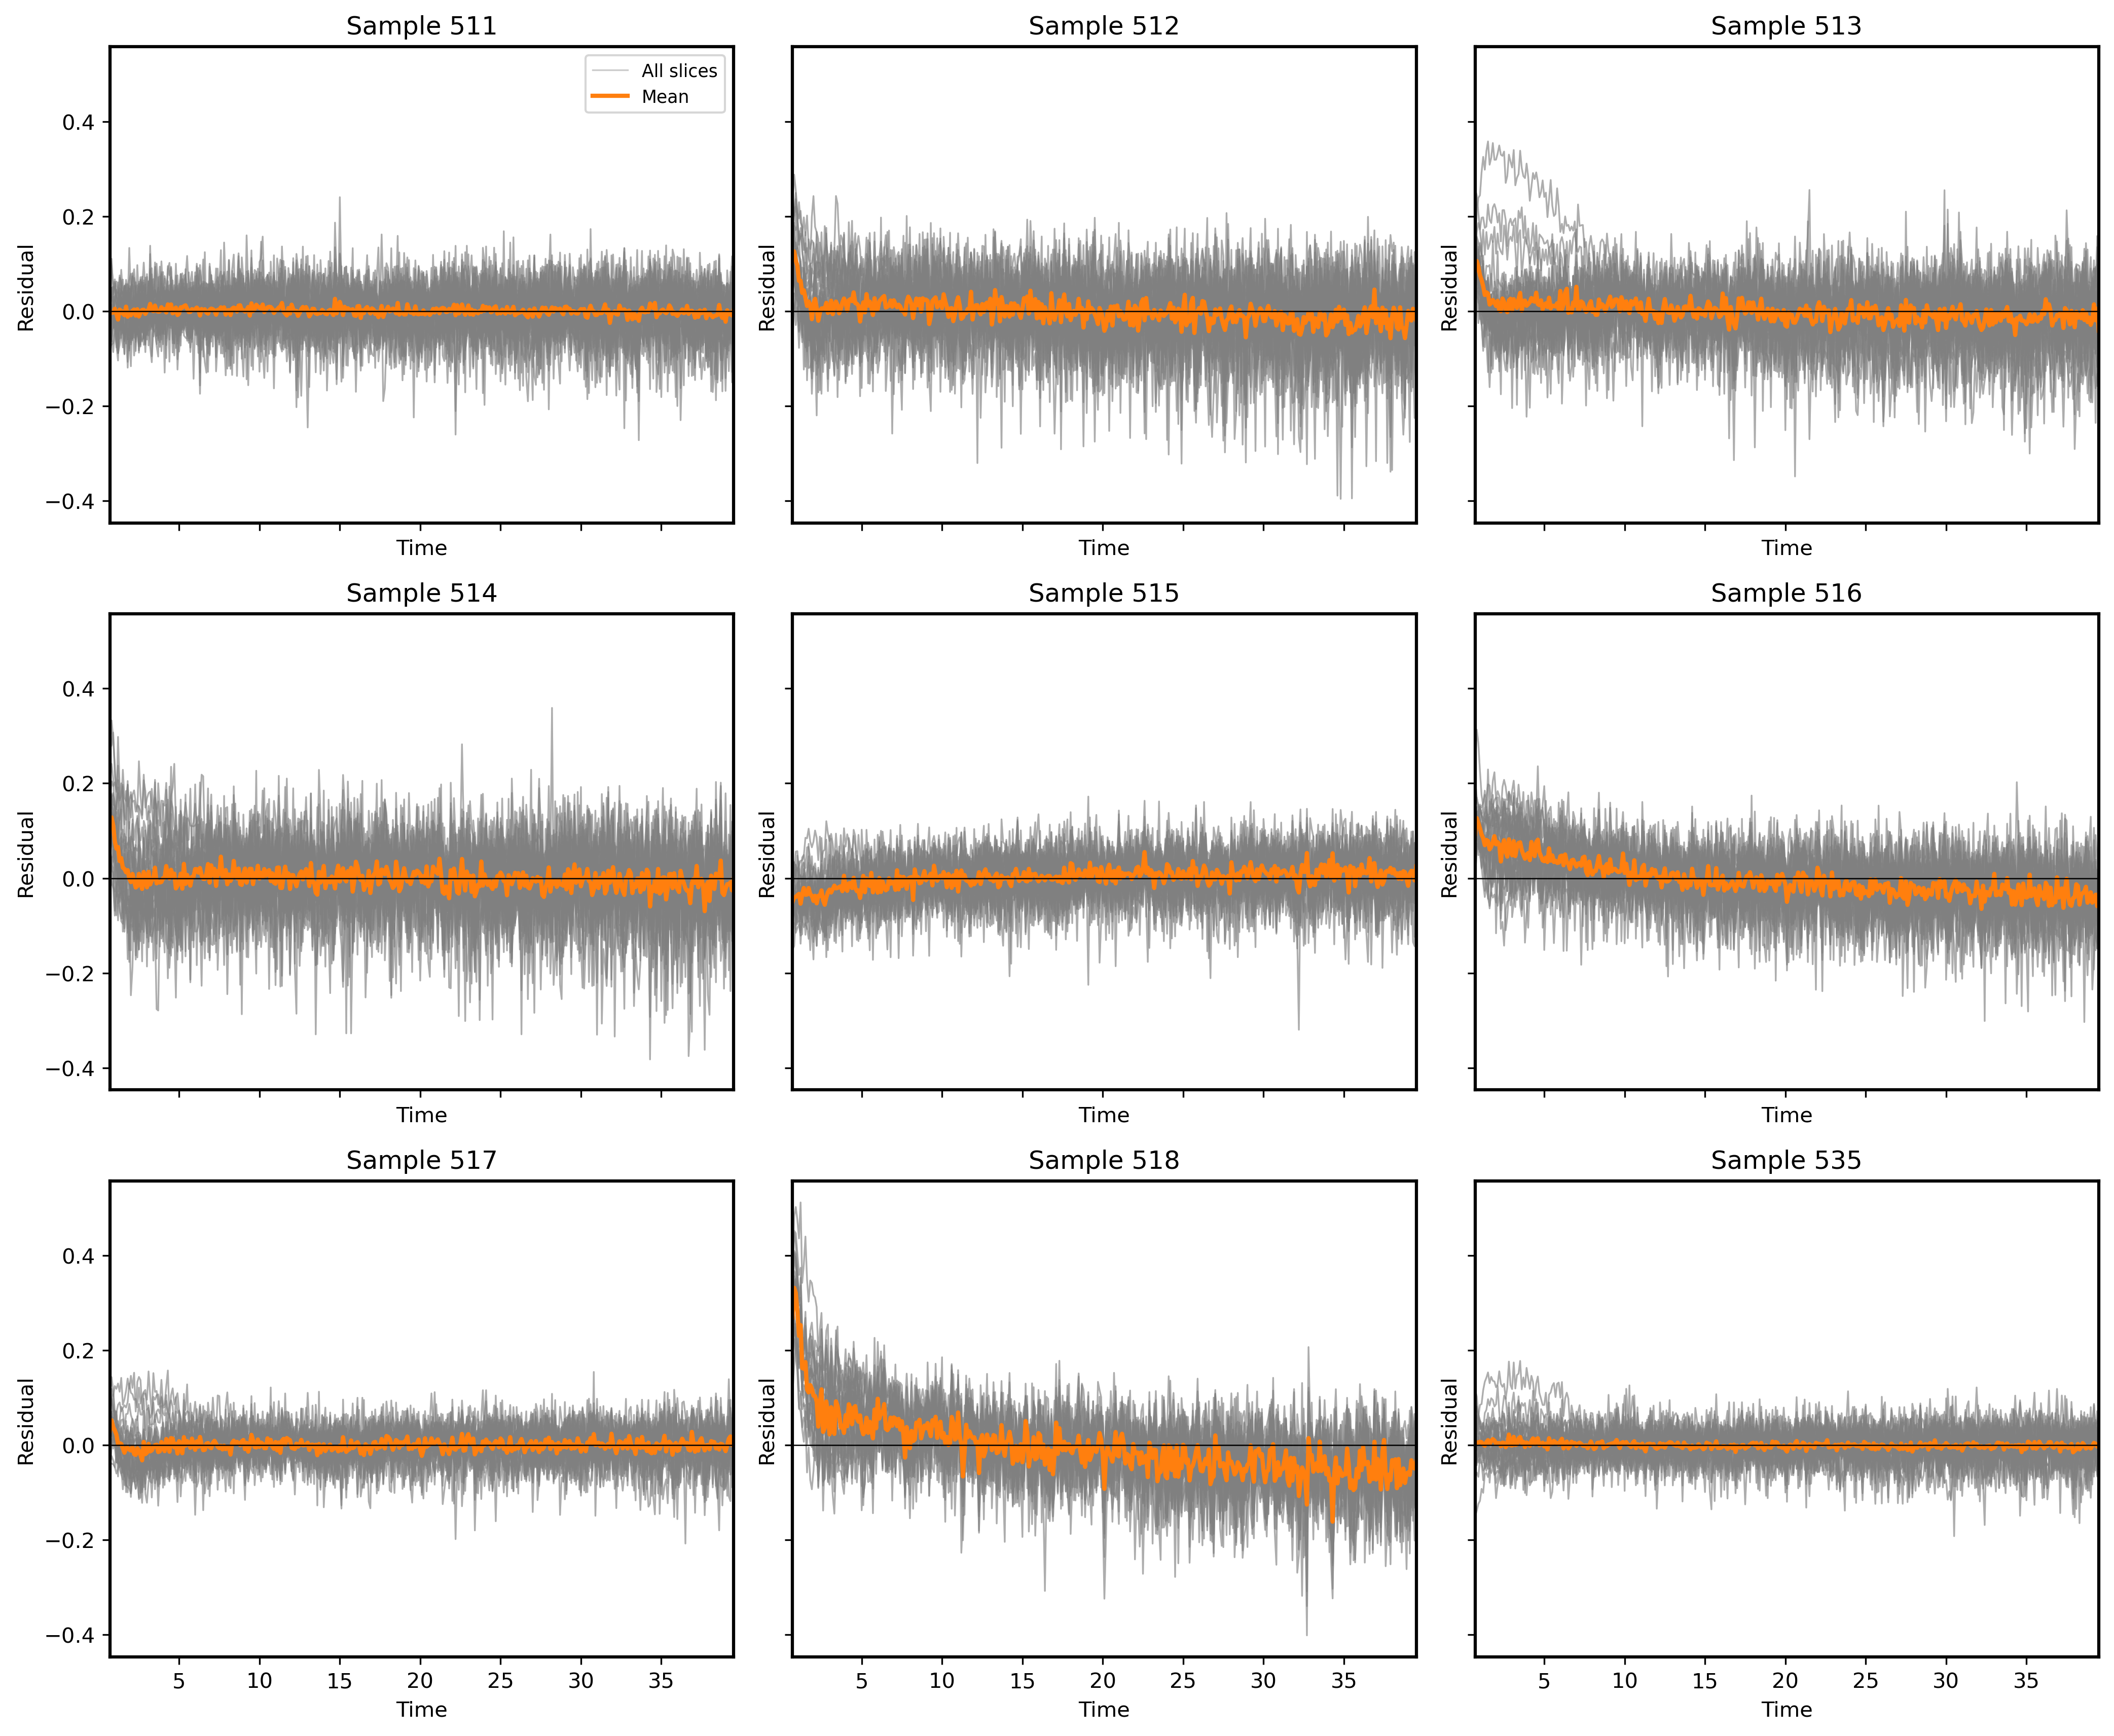

In [42]:
# ==================================================================
# 3×3 GRID OF RESIDUALS – every slice, every sample
# ==================================================================
samples       = sorted(results_df['sample'].unique())   # 9 samples
n_rows, n_cols = 3, 3
fig, axes      = plt.subplots(n_rows, n_cols,
                              figsize=(14, 12), sharex=True, sharey=True, dpi=300)

for ax, s in zip(axes.ravel(), samples):
    # pull slice‑level rows for this sample
    grp = results_df.loc[results_df['sample'] == s]

    # fetch raw data once
    time, Xs, slice_cols = sample_matrix(s)

    # ----- plot residual of every slice ---------------------------
    for _, row in grp.iterrows():
        idx = np.where(slice_cols == row['slice'])[0][0]
        y   = Xs[idx]
        yhat = row['A'] * source1 + row['B'] * source2
        
        ax.plot(time, y - yhat, color='grey', alpha=0.4, lw=0.8)
        # add label to the first slice only
        if idx == 0:
            ax.plot(time, y - yhat, color='grey', alpha=0.4, lw=0.8, label='All slices')
        else:
            ax.plot(time, y - yhat, color='grey', alpha=0.4, lw=0.8)
        


    # optional: mean residual curve in bold
    mean_res = np.mean([
        Xs[np.where(slice_cols == r['slice'])[0][0]] -
        (r['A']*source1 + r['B']*source2)
        for _, r in grp.iterrows()
    ], axis=0)
    ax.plot(time, mean_res, color='tab:orange', lw=2,
            label='Mean')

    ax.axhline(0, color='k', lw=0.6)
    ax.set(title=f'Sample {s}', xlabel='Time', ylabel='Residual')

    # set x lim to the min/max of all samples
    ax.set_xlim(time.min(), time.max())

    # show legend only on the first axis
    if ax == axes[0, 0]:
        ax.legend(loc='upper right', fontsize='small', ncol=1)

    # cosmetics
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# hide any unused axes (if fewer than 9 samples)
for ax in axes.ravel()[len(samples):]:
    ax.axis('off')

# shared legend (mean residual)
# fig.legend(['Mean residual'], loc='upper center', ncol=1)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# save the PNG and PDF files with dpi=600 under '/Figures'
fig.savefig('Figures/residuals.png', dpi=600, bbox_inches='tight')
fig.savefig('Figures/residuals.pdf', dpi=600, bbox_inches='tight')


===== BASIS–COLLINEARITY CHECK =====
Cosine similarity(source1, source2) = 0.9998
Condition number of S               = 9.77e+01

===== RESIDUAL ANALYSIS =====
Slices with A or B outside [0,1]: 109 of 215 (50.7 %)


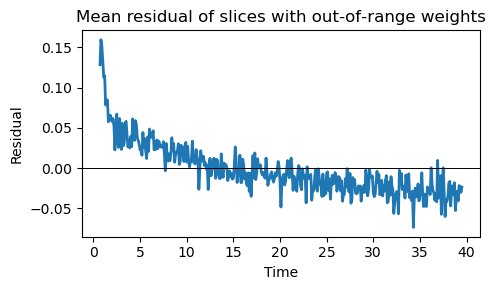

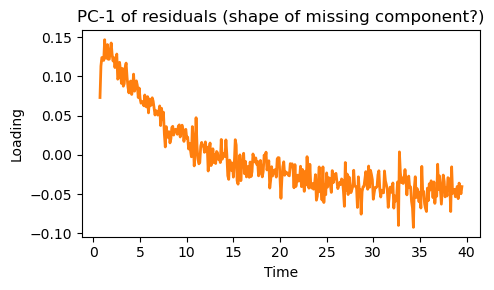

In [17]:
# ==================================================================
# DIAGNOSTICS  (run after results_df is ready)
# ==================================================================
import seaborn as sns
from sklearn.decomposition import PCA

# ------------------------------------------------
# ❶  Are the two source curves almost collinear?
# ------------------------------------------------
s1n = source1 / np.linalg.norm(source1)
s2n = source2 / np.linalg.norm(source2)
cos_sim   = float(np.dot(s1n, s2n))              # 1 = perfect collinear
cond_num  = np.linalg.cond(S)

print("\n===== BASIS–COLLINEARITY CHECK =====")
print(f"Cosine similarity(source1, source2) = {cos_sim:.4f}")
print(f"Condition number of S               = {cond_num:.2e}")

# rule of thumb:  cos_sim > 0.9  or  cond_num > 1e4  → ill‑conditioned

# ------------------------------------------------
# ❷  Examine slices with out‑of‑bounds weights
# ------------------------------------------------
bad_mask = (results_df['A'] < 0) | (results_df['A'] > 1) | \
           (results_df['B'] < 0) | (results_df['B'] > 1)

n_bad = bad_mask.sum()
print(f"\n===== RESIDUAL ANALYSIS =====")
print(f"Slices with A or B outside [0,1]: {n_bad} "
      f"of {len(results_df)} ({100*n_bad/len(results_df):.1f} %)")

if n_bad > 0:
    # pull residuals for those slices
    residual_list = []
    for _, row in results_df[bad_mask].iterrows():
        sample_key, slice_name = row['sample'], row['slice']
        time, Xs, slice_cols   = sample_matrix(sample_key)
        idx = np.where(slice_cols == slice_name)[0][0]
        y   = Xs[idx]
        yhat = row['A']*source1 + row['B']*source2
        residual_list.append(y - yhat)
    R_bad = np.vstack(residual_list)          # (n_bad × n_time)

    # ---- (a) mean residual curve ---------------------------------
    plt.figure(figsize=(5,3))
    plt.plot(time, R_bad.mean(axis=0), lw=2)
    plt.axhline(0, color='k', lw=0.7)
    plt.title('Mean residual of slices with out‑of‑range weights')
    plt.xlabel('Time');  plt.ylabel('Residual')
    plt.tight_layout();  plt.show()

    # ---- (b) first PC of those residuals -------------------------
    pca_r = PCA(n_components=1).fit(R_bad - R_bad.mean(0, keepdims=True))
    pc1   = pca_r.components_[0]
    plt.figure(figsize=(5,3))
    plt.plot(time, pc1, lw=2, color='tab:orange')
    plt.title('PC‑1 of residuals (shape of missing component?)')
    plt.xlabel('Time');  plt.ylabel('Loading')
    plt.tight_layout();  plt.show()

else:
    print("No out‑of‑range slices – nothing to analyse.")
